## European Restaurant Reviews

In [ ]:
import pandas as pd
import numpy as np
import string
import tqdm
import joblib 
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder ,StandardScaler
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.metrics import roc_auc_score

import nltk 
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords

import gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.utils import tokenize

from transformers import GPT2Tokenizer

from  catboost import CatBoostClassifier

pd.options.mode.chained_assignment = None

### work with data

In [3]:
data=pd.read_csv(r'E:\mphti\training\restoraunt\European Restaurant Reviews.csv')

In [4]:
data.head(2)

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."


Based on the review, we will look for a restaurant similar to it. I chose it because it is simple and it will probably suit me to begin with

In [5]:
data_rev=data[['Sentiment','Review']]
#data_rev.head(5)

In [6]:
# let 's see if there are zero values
print(f'{data_rev.isna().sum()}')

Sentiment    0
Review       0
dtype: int64


In [7]:
# are there duplicates
duplicates_number = data_rev[data_rev['Review'].duplicated()]
print(f'Number of duplicate {len(duplicates_number)}')

Number of duplicate 76


In [8]:
# delete duplicate reviews
duplicate=list(duplicates_number.index)
data_rev.drop(index= duplicate , inplace=True)

data_rev.value_counts(data_rev['Sentiment'])

Sentiment
Positive    1237
Negative     189
Name: count, dtype: int64

In [9]:
# encode sentiments label
encode=preprocessing.LabelEncoder()
data_rev['Sentiment']=encode.fit_transform(data_rev['Sentiment'])
data_rev.head(2)

,Sentiment,Review
0,0,The manager became agressive when I said the c...
1,0,"I ordered a beef fillet ask to be done medium,..."


### work with text in reviews

In [11]:
# on of reviews
data_rev['Review'][0]

'The manager became agressive when I said the carbonara was not good. She was rude. It was  a very bad experience. The worst in Rome in many years.'

In [12]:
# define stopwors set
stops = set(stopwords.words('english')).union(set(string.punctuation))
# define embedding
emb_so=KeyedVectors.load_word2vec_format(r'E:\mphti\training\restoraunt\SO_vectors_200.bin',binary=True)
emb_cl=KeyedVectors.load_word2vec_format(r'E:\mphti\training\restoraunt\glove.840B.300d_word2vec.bin',binary=True)
# define tokenizer
tokenz_gn=tokenize
tokenz_nltk=WordPunctTokenizer()

# tokenz_gpt = GPT2Tokenizer.from_pretrained('gpt2')  # он сразу кодирует слова (не нужен емб)
# 18 sec

In [13]:
# check embedding
# t1 =emb_cl.similar_by_word("bad")[:3]
# t2 =emb_so.similar_by_word("bad")[:3]
# print (t1,t2)

теперь надо векторизировать текст ревью и подготовить для модели

In [14]:
def txt2vec(text,tokenizer,embedding,dim):
    '''
    Embeds a sentence into vector representations

        :param text: str
        :param tokenizer: tokenizer that used to
        :param embeddings: embedidngs
        :param dim: size of any vector in repr

        return: embeddings of a text
    '''
    # формируем токены из текста
    if tokenizer==tokenz_gn:
        tokenz=list(tokenz_gn(text.lower(),deacc = True))
    elif tokenizer==tokenz_nltk:
        tokenz=tokenz_nltk.tokenize(text.lower())

    vecs=[]
    # представляем токен как вектор похожих слов из embedding
    for token in tokenz:
        
        if token not in stops:
            if token in embedding:
                # print ('emb_cl')
                vecs.append(embedding[token])
                
    # елси не нашло ничего то нулевой вектор
    if not vecs:
        return np.zeros(dim,dtype='float32')
    # считаем среднее для текста на основе всех слов 
    mean_v=np.mean(vecs,axis=0)
    # print (mean_v[:4])
    return mean_v

# sentence=data_rev['Review'][1]
# print()
# t=txt2vec(sentence,tokenz_gn,emb_cl,300)

In [15]:
def frame_t2v(data,column,tokenizer,embedding,dim):
    '''
    Embeds a sentence into vector representations

        :param data: DataFrame
        :param column: culumn with text
        :param tokenizer: tokenizer that used to
        :param embeddings: embedidngs
        :param dim: size of any vector in repr

        return: dataframe of vectorized review texts
    '''
    # проходим по датасету
    n=1
    frame=pd.DataFrame()
    for i in data[column]:
        # векторизируем текст 
        vector=txt2vec(i,tokenizer,embedding,dim)
        series=pd.Series(vector).to_frame(f'wgh_{n}')
        frame=pd.concat([frame,series],axis=1)
        n=n+1

    frame=frame.T
    return frame

data_rev_t2v=frame_t2v(data_rev,'Review',tokenz_gn,emb_cl,300)


In [ ]:
# rename columns
name={i :f'txt_{i}' for i in range(0,data_rev_t2v.shape[1])}
data_rev_t2v=data_rev_t2v.rename(columns=name)

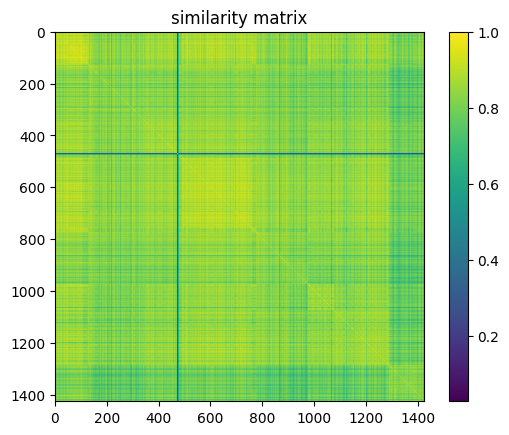

In [17]:
similarity_mat=cosine_similarity(data_rev_t2v.to_numpy(),data_rev_t2v.to_numpy())
plt.imshow(similarity_mat)
plt.title('similarity matrix')
plt.colorbar()
plt.show()

most of the values in the matrix are close to 0.8 . this is a good result. It is possible to closely predict the similarity of the text that we are studying to the text that it should be similar to.

### Classification

In [ ]:
le=LabelEncoder()
st=StandardScaler()

In [20]:
# are there duplicates
duplicates_number = data[data['Review'].duplicated()]
# delete duplicate reviews
duplicate=list(duplicates_number.index)
data_m=data.drop(index= duplicate)

In [21]:
data_m.value_counts(data_m['Country'])

Country
France     490
Italy      270
Morroco    210
Cuba       140
Poland     135
Russia     100
India       81
Name: count, dtype: int64

In [22]:
data_m.value_counts(data_m['Restaurant Name'])

Restaurant Name
The Frog at Bercy Village                490
Ad Hoc Ristorante (Piazza del Popolo)    270
The LOFT                                 210
Old Square (Plaza Vieja)                 140
Stara Kamienica                          135
Pelmenya                                 100
Mosaic                                    81
Name: count, dtype: int64

the conclusion is that the Country and Restaurant Name signs will not be informative and you can leave one of them

In [23]:
data_rev_t2v['country']=le.fit_transform(data_m['Country'])
data_rev_t2v=st.fit_transform(data_rev_t2v)
data_m['Sentiment']=le.fit_transform(data_m['Sentiment'])

X_train, X_test,y_train,y_test= train_test_split(data_rev_t2v,data_m['Sentiment'],test_size=0.25,shuffle=True,random_state=50)

In [22]:
cbc=CatBoostClassifier(    
    loss_function='Logloss',
    verbose=False,
    task_type="GPU"
)

parametrs={
    'n_estimators':range(20,140,10),
    'learning_rate': np.linspace(0.001,0.01,10),
    'max_depth':range(5,10,2),
    'l2_leaf_reg':range(0,80,10),
}

random_search_cat=RandomizedSearchCV(
    estimator=cbc,
    param_distributions=parametrs,
    n_iter=10,
    n_jobs=1,
    cv=5,
    scoring='accuracy'
)

random_search_cat.fit(X_train, y_train)
print(f'{random_search_cat.best_params_,random_search_cat.score(X_train, y_train)}\n')

roc_cat=roc_auc_score(y_test,random_search_cat.predict_proba(X_test)[:,-1])
print (roc_cat)


({'n_estimators': 20, 'max_depth': 7, 'learning_rate': 0.008, 'l2_leaf_reg': 0}, 0.9915809167446211)

0.9831181727904668


In [ ]:
# save the model 
filename = 'ran_cat_boost.pt'
joblib.dump(random_search_cat, open(filename, 'wb')) 

In [24]:
# load the model 
load_model = joblib.load(open(filename, 'rb')) 
  
y_pred = load_model.predict(X_test) 
print('root mean squared error : ', roc_auc_score(y_test, y_pred))

root mean squared error :  0.8191099801390268
